<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/timeSeriesStationary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:.2f}'.format #Change display format in DataFrame table

In [ ]:
# Import data
df = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/macroData.csv',
                 parse_dates = ['Date'],
                 index_col = ['Date'],
                 dayfirst = True)
df.head(5)

,FDI,HD,GDP,RSI,CPI,Wage,UR,OP,Im,Ex,PCI,CCI,API,PII,MPI,PIR
Date,,,,,,,,,,,,,,,,
1993-03-01,nan,nan,1067301.00,nan,50.30,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1993-04-01,nan,nan,nan,nan,50.90,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1993-05-01,nan,nan,nan,nan,51.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1993-06-01,nan,nan,1039924.00,nan,51.10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1993-07-01,nan,nan,nan,nan,51.60,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [ ]:
# Imputation for macroeconomics variables
df = df.interpolate(method = 'cubic', limit_direction = 'forward', axis = 0)
df.head(5)

,FDI,HD,GDP,RSI,CPI,Wage,UR,OP,Im,Ex,PCI,CCI,API,PII,MPI,PIR
Date,,,,,,,,,,,,,,,,
1993-03-01,nan,nan,1067301.00,nan,50.30,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1993-04-01,nan,nan,1045806.51,nan,50.90,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1993-05-01,nan,nan,1037665.33,nan,51.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1993-06-01,nan,nan,1039924.00,nan,51.10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1993-07-01,nan,nan,1050129.20,nan,51.60,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [ ]:
# Data period for modelling is Jan-2914 to Nov-2018 (Nov-2019)
# 'seasonal_decompose' cannot deal with missing values
dfRAW = df.loc['2014-01-01':'2018-11-01']
print(f'Checking for missing values:\n{dfRAW.isnull().sum()}')

Checking for missing values:
FDI     0
HD      0
GDP     0
RSI     0
CPI     0
Wage    0
UR      0
OP      0
Im      0
Ex      0
PCI     0
CCI     0
API     0
PII     0
MPI     0
PIR     0
dtype: int64


In [ ]:
# Define better plot function
def plotSeasonal(result, axs):
  result.observed.plot(ax = axs[0], legend = False)
  axs[0].set_ylabel('Observed')
  result.trend.plot(ax = axs[1], legend = False)
  axs[1].set_ylabel('Trend')
  result.seasonal.plot(ax = axs[2], legend = False)
  axs[2].set_ylabel('Seasonal')
  result.resid.plot(ax = axs[3], legend = False)
  axs[3].set_ylabel('Residual')
  return

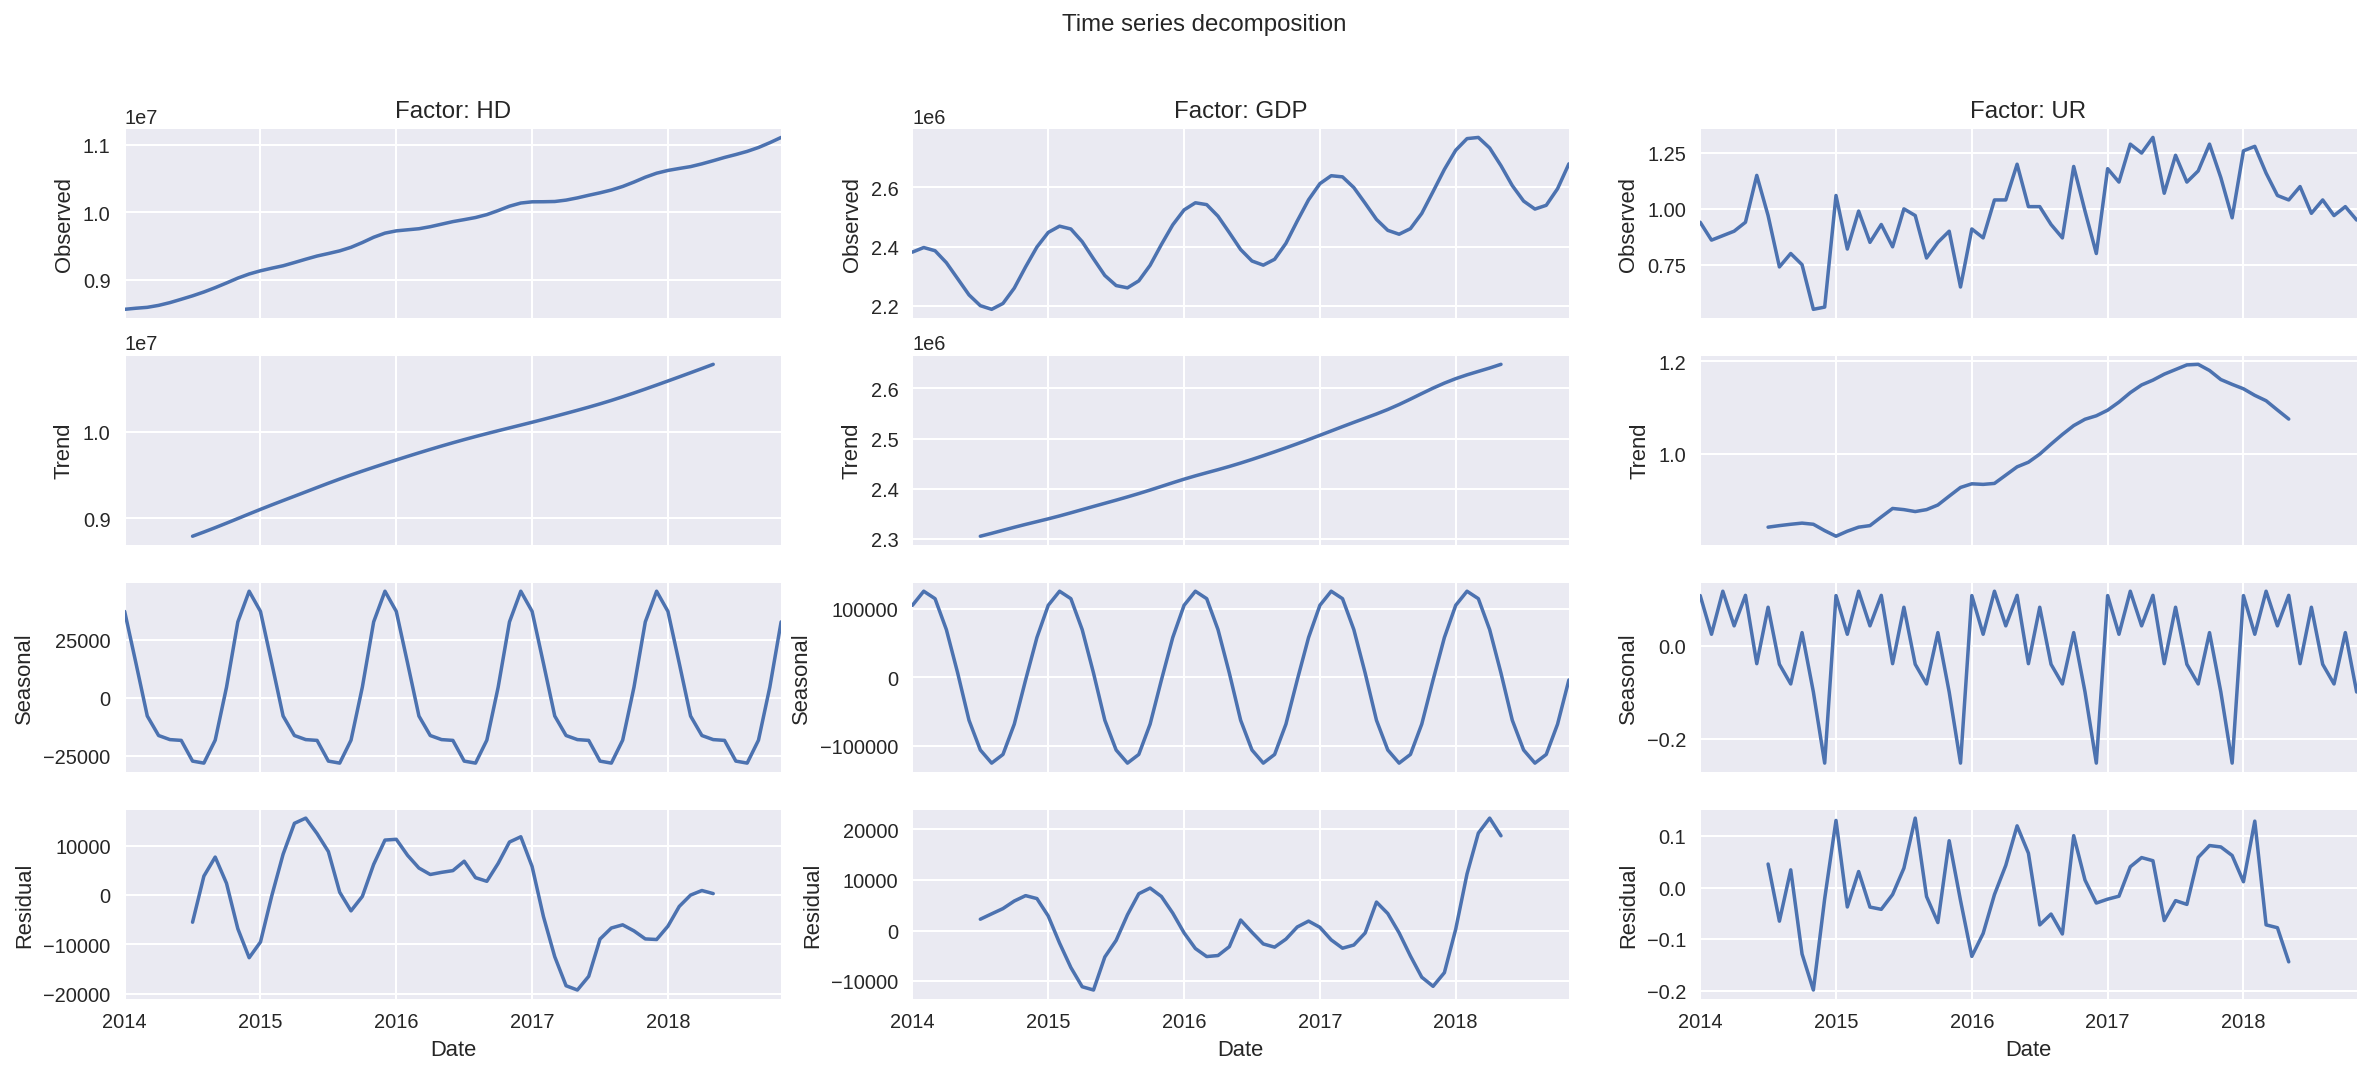

In [ ]:
# Time series decomposition
factorList = ['HD', 'GDP', 'UR']

with plt.style.context('seaborn'):
  fig, axs = plt.subplots(4, len(factorList), figsize = (20, 8), sharex = True)
  fig.suptitle('Time series decomposition')
  for i, factor in enumerate(factorList):
    results = seasonal_decompose(dfRAW[factor], model = 'additive')
    axs[0, i].set_title(f'Factor: {factor}') #Add title at the first plot in sub-plot
    plotSeasonal(results, axs[:, i])
  plt.show()

In [ ]:
# Transformation variables
# Keep sing of variables for a purpose
# Import data
mainList = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/macroSign.csv')

# Create variable group
mainList['Group'] = mainList['Variable'] #Originate group before transformation

# Transformation to reduce unit root in variables and become more stationary
# First transformation
mainSign = mainList.to_numpy() #To keep originate sign before transformation
mainCols = df.columns #List of all variables that will be transformed

# Log transformation
for variable in mainCols:
  # Transform
  df[f'{variable}_LN'] = np.log(df[variable])
  # Keep sign
  sign = mainList.query("Variable == @variable").values
  sign[0][0] = df.columns[-1] #Change variable name to transformed name
  mainSign = np.vstack((mainSign, sign)) #Stack with originate sign

# Moving average transformation
windows = [3, 6, 9, 12]

for variable in mainCols:
  for window in windows:
    df[f'{variable}_M{window}'] = df[variable].rolling(window = window).mean()
    sign = mainList.query("Variable == @variable").values
    sign[0][0] = df.columns[-1]
    mainSign = np.vstack((mainSign, sign))

# Year on year change transformation
# Rate variable using simple diff
for variable in mainList.query("Type == 'Rate'")['Variable']:
  df[f'{variable}_C'] = df[variable].diff(12)
  sign = mainList.query("Variable == @variable").values
  sign[0][0] = df.columns[-1]
  mainSign = np.vstack((mainSign, sign))

# Non-Rate variable using log diff
for variable in mainList.query("Type != 'Rate'")['Variable']:
  df[f'{variable}_C'] = np.log(df[variable]).diff(12)
  sign = mainList.query("Variable == @variable").values
  sign[0][0] = df.columns[-1]
  mainSign = np.vstack((mainSign, sign))

# Format to DataFrame
mainList = pd.DataFrame(mainSign, columns = mainList.columns)
mainList.tail(5)

,Variable,Type,Sign,Group
107,PCI_C,Index,-1,PCI
108,CCI_C,Index,-1,CCI
109,API_C,Index,-1,API
110,PII_C,Index,-1,PII
111,MPI_C,Index,-1,MPI


In [ ]:
# Second transformation
mainSign = mainList.to_numpy()

# Lag transformation
lags = 12 #Define lag range

for variable in df.columns:
  for lag in range(1, lags + 1):
    df[f'{variable}_lg{lag}'] = df[variable].shift(lag)
    sign = mainList.query("Variable == @variable").values
    sign[0][0] = df.columns[-1]
    mainSign = np.vstack((mainSign, sign))

# Format to DataFrame
mainList = pd.DataFrame(mainSign, columns = mainList.columns)

# Export to csv
mainList.to_csv('macroSignTransformed.csv', index = 0)

In [ ]:
# Selection data for stationary analysis
df = df.loc['2014-01-01':'2018-11-01']

# Export to csv
df.to_csv('macroTransformed.csv', index = 1)

In [ ]:
# Stationary analysis
# ADF
ADFResults = []

for variable in df.columns:
  adf, _, _, _, criticalValues, _ = adfuller(df[variable], regression = 'nc', autolag = 'AIC')
  if adf <= criticalValues['5%']:
    result = 'Stationary'
  else:
    result = 'Unit root'
  ADFResults.append([variable, adf, result])

# Format to DataFrame
ADFResults = pd.DataFrame(ADFResults, columns = ['Variable', 'ADFStat', 'Result'])

# Export to csv
ADFResults.to_csv('stationaryResults.csv', index = 0)

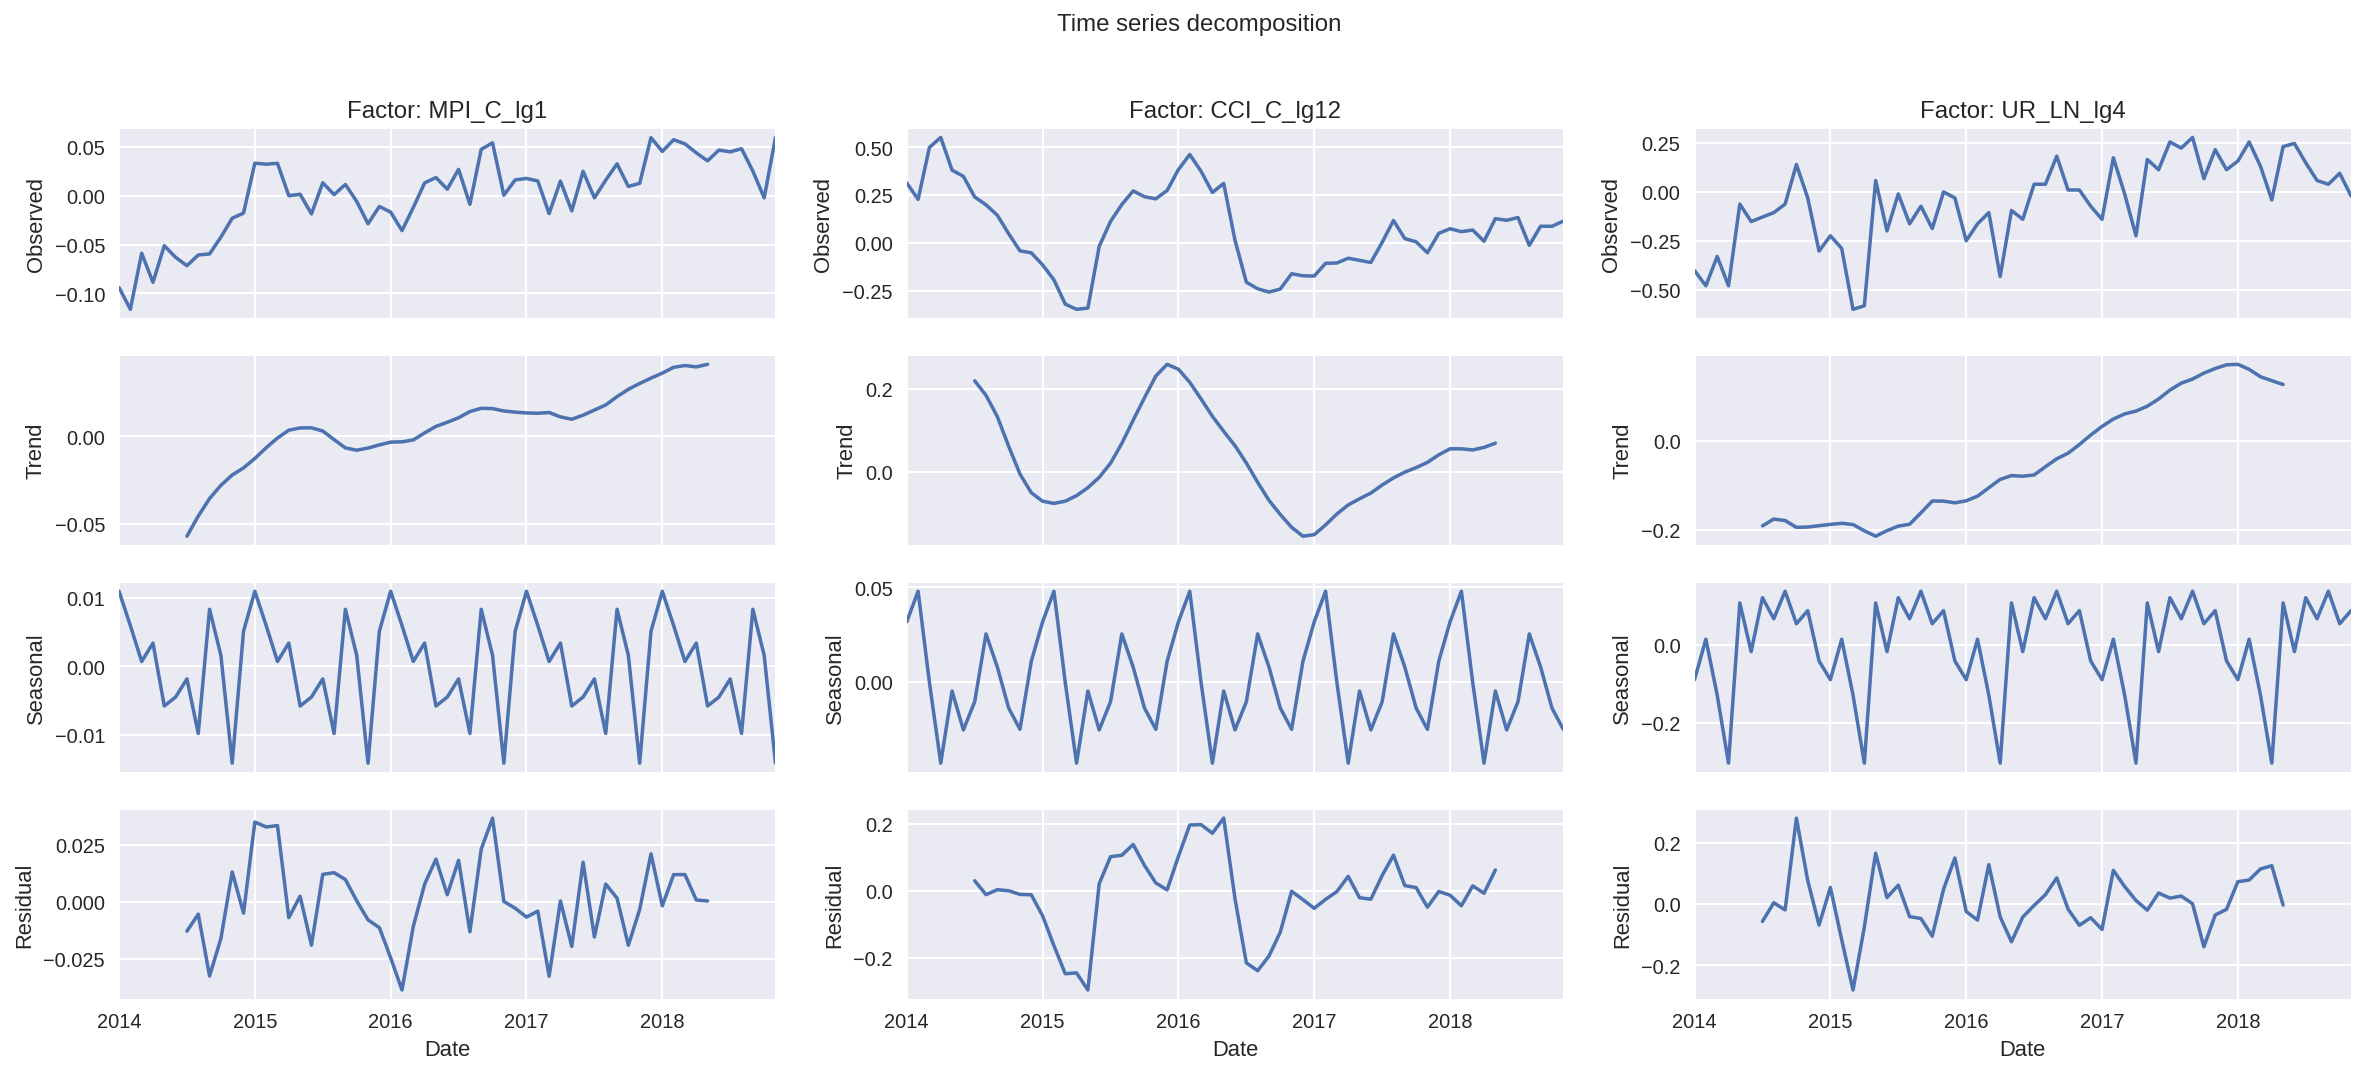

In [ ]:
# Stationary result
stationaryList = np.random.choice(ADFResults.query("Result == 'Stationary'")['Variable'].values, 3)

with plt.style.context('seaborn'):
  fig, axs = plt.subplots(4, len(stationaryList), figsize = (20, 8), sharex = True)
  fig.suptitle('Time series decomposition')
  for i, factor in enumerate(stationaryList):
    results = seasonal_decompose(df[factor], model = 'additive')
    axs[0, i].set_title(f'Factor: {factor}')
    plotSeasonal(results, axs[:, i])
  plt.show()